# Pràctica 3: Controlant el robot amb una Xarxa Neuronal

## Introducció

En aquesta pràctica es pretén controlar un robot amb una xarxa neuronal. Per això, entrenarem una xarxa neuronal amb dades de sensors del robot i les comandes que s'han de donar al robot per segueixi la pista. Un cop entrenada la xarxa, es podrà utilitzar per controlar el robot.

In [63]:
!pip install aitk aitk.robots aitk.networks tensorflow numpy

In [64]:
import random

import aitk.networks as nets
import numpy as np
import aitk.robots as bots

import keras

import matplotlib.pyplot as plt
import cv2
import requests

## Creant la funció per llegir les dades d'entrenament
Crearem una funció que llegeixi les dades d'entrenament i ens retorni una llista de patrons on cada element de la llista és un patró d'entrada i un patró de sortida. A més, ens mostrarà el nombre de patrons llegits.

In [65]:
def carrega_dades_entrenament(nom_fitxer):
    """Retorna les dades d'entrenament"""
    
    data = []
    with open(nom_fitxer, "r") as f:
        for line in f:
            split_line = line.strip().split(" ")
            float_line = [float(x) for x in split_line]
            data.append(float_line)
    print(len(data), " exemples carregats")
    return data

In [66]:
patrons = carrega_dades_entrenament("training_data.txt")
len(patrons)

6000  exemples carregats


6000

In [67]:
# Vejam quants paràmetres tenen els patrons
print(len(patrons[0]))

3


In [68]:
# Observem un exemple
print(patrons[0])

[0.5, 1.0, 0.0]


## Preprocessament i balanceig de les dades

Les eines de machine learning, incloses les xarxes neuronals, trobaran la manera més directa de reduir l'error. Farem una mica d'anàlisi de les dades que hem recollit. Crearem una funció auxiliar per comptar quin percentatge de les nostres dades d'entrenament fan que el robot es mogui cap endavant, es mogui cap a l'esquerra o es mogui cap a la dreta.

La funció hauria de prendre una llista de patrons com a entrada i retornar una llista de tres valors: el percentatge de patrons amb moviment cap endavant, el percentatge de patrons amb moviment cap a l'esquerra i el percentatge de patrons amb moviment cap a la dreta.

In [69]:
def classifica_moviments(patterns):
    """Retorna una llista de tres valors: 
       - el percentatge de patrons amb moviment cap endavant, 
       - el percentatge de patrons amb moviment cap a l'esquerra i 
       - el percentatge de patrons amb moviment cap a la dreta."""
    forward = 0
    left = 0
    right = 0
    for pattern in patterns:
        if pattern[-1] > 0.1:
            right += 1
        elif pattern[-1] < -0.1:
            left += 1
        else:
            forward += 1
    total = forward + left + right
    print("forward: ", forward)
    print("left: ", left)
    print("right: ", right)
    return [forward / total, left / total, right / total]

In [70]:
classifica_moviments(patrons)

forward:  3540
left:  2220
right:  240


[0.59, 0.37, 0.04]

En la robótica és típic que el robot es mogui més cap a l'objectiu que cap a la dreta o cap a l'esquerra. Per tant, és probable que la xarxa neuronal aprengui a moure's cap a l'objectiu i no a girar. Per això, és important que les dades estiguin balancejades. Per aconseguir-ho, dividirem les dades en tres llistes, una per cada tipus de moviment, i barrejarem les llistes. A continuació, agafarem el mateix nombre de patrons de cada llista i les barrejarem de nou. Això ens donarà un conjunt de dades balancejat.

In [71]:
def balanceja_moviments(patrons):
    """Returns a list of patterns with an equal number of examples for each type of movement."""
    patrons_sense_duplicats = set(tuple(x) for x in patrons)
    forward = []
    left = []
    right = []
    for patro in patrons_sense_duplicats:
        if patro[-1] > 0.2:
            right.append(patro)
        elif patro[-1] < -0.2:
            left.append(patro)
        else:
            forward.append(patro)

    min_length = min(len(forward), len(left), len(right))
    forward = random.sample(forward, min_length)
    left = random.sample(left, min_length)
    right = random.sample(right, min_length)

    balanced = forward + left + right
    random.shuffle(balanced)
    return balanced

In [72]:
patrons_balancats = balanceja_moviments(patrons)
print(len(patrons_balancats))

21


Podem intentar entrenar la xarxa neuronal amb les dades balancejades i veure com es comporta. Si la xarxa neuronal no aprèn, podem provar amb el conjunt de dades original.

In [73]:
patrons_entrenament = patrons[:int(len(patrons) * 0.8)]
patrons_validacio = patrons[int(len(patrons) * 0.8):]

def separa_dades(dades):
    """Retorna dues llistes: una amb les dades d'entrada i l'altra amb les dades de sortida."""
    x = []
    y = []
    for dada in dades:
        x.append(dada[0])
        y.append(dada[-2:])
    return x, y

x_train, y_train = separa_dades(patrons_entrenament)
x_test, y_test = separa_dades(patrons_validacio)

print(len(x_train), len(y_train))
print(x_train)
print(y_train)


4800 4800
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.51, 0.51, 0.52, 0.53, 0.53, 0.54, 0.56, 0.57, 0.56, 0.55, 0.55, 0.56, 0.56, 0.56, 0.55, 0.55, 0.57, 0.58, 0.57, 0.57, 0.58, 0.58, 0.57, 0.58, 0.57, 0.57, 0.56, 0.55, 0.54, 0.54, 0.54, 0.54, 0.55, 0.55, 0.56, 0.56, 0.56, 0.55, 0.55, 0.54, 0.53, 0.53, 0.52, 0.52, 0.51, 0.5, 0.5, 0.49, 0.48, 0.47, 0.47, 0.46, 0.45, 0.44, 0.44, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.46, 0.46, 0.47, 0.47, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.55, 0.57, 0.58, 0.59, 0.59, 0.59, 0.58, 0.57, 0.56, 0.55, 0.54, 0.54, 0.57, 0.58, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.58, 0.57, 0.55, 0.55, 0.55, 0.54, 0.54, 0.54, 0.54, 0.54, 0.55, 0.55, 0.56, 0.56, 0.54, 0.53, 0.53, 0.51, 0.51, 0.5, 0.49, 0.49, 0.48, 0.48, 0.47, 0.47, 0.46, 0.45, 0.46, 0.45, 0.46, 0.46, 0.47, 0.47, 0.48, 0.5, 0.52, 0.55, 0.57, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.66, 0.67, 0.69, 0.7, 0.72, 0.72, 0.73, 0.73, 0.73, 0.73, 0.72, 0.71, 0.7, 0.68, 0.66, 0.6

## Crear la xarxa de control del robot

Crearem una xarxa neuronal amb tres capes: entrada, oculta i sortida. Les entrades representaran els sensors del robot i les sortides representaran les accions del robot. La capa oculta ajudarà a transformar els sensors en les accions adequades.

La xarxa ha de tenir tantes entrades com hàgiu utilitzat en el vostre algorisme. Nosaltres solament utilitzem el centre de la imatge, per lo que solament hi ha una entrada. Podeu haver utilitzat un enfocament diferent, com utilitzar tota la imatge o utilitzar més d'un sensor. En aquest cas, haureu de tenir més entrades.

Podem utilitzar `SimpleNetwork` de `aitk.networks` per crear la xarxa, per la seva simplicitat e integració amb `aitk.robots` o `keras` per la seva flexibilitat.

Comeceu amb una mida de capa oculta de 5, però podeu experimentar amb això per veure quina mida funciona millor.

La mida de la capa de sortida ha de ser 2, ja que aquesta capa representa les quantitats de traducció i rotació per moure el robot.

In [74]:
robot_net = nets.SimpleNetwork(1, 5, 2, activation="tanh", optimizer="adam", loss="mse")

El següent pas és entrenar la xarxa neuronal. Degut a la naturalesa de les dades, és probable que necessitem més èpoques d'entrenament que en altres tasques.

In [75]:
robot_net.fit(x_train, y_train, epochs=10000, batch_size=10000, validation_data=(x_test, y_test), report_rate=100)

KeyboardInterrupt: 

In [81]:
robot_net = keras.Sequential([
    keras.layers.Dense(5, activation="relu", input_shape=(1,)),
    keras.layers.Dense(2, activation="tanh")
])

robot_net.compile(optimizer="adam", loss="mse")
robot_net.fit(x_train, y_train, epochs=10000, batch_size=10000, validation_data=(x_test, y_test))

Epoch 1/10000
1/1 [==============================] - 0s 306ms/step - loss: 0.5115 - val_loss: 0.5096
Epoch 2/10000
1/1 [==============================] - 0s 37ms/step - loss: 0.5096 - val_loss: 0.5077
Epoch 3/10000
1/1 [==============================] - 0s 37ms/step - loss: 0.5077 - val_loss: 0.5059
Epoch 4/10000
1/1 [==============================] - 0s 40ms/step - loss: 0.5059 - val_loss: 0.5040
Epoch 5/10000
1/1 [==============================] - 0s 40ms/step - loss: 0.5040 - val_loss: 0.5022
Epoch 6/10000
1/1 [==============================] - 0s 29ms/step - loss: 0.5022 - val_loss: 0.5003
Epoch 7/10000
1/1 [==============================] - 0s 64ms/step - loss: 0.5003 - val_loss: 0.4985
Epoch 8/10000
1/1 [==============================] - 0s 31ms/step - loss: 0.4985 - val_loss: 0.4967
Epoch 9/10000
1/1 [==============================] - 0s 29ms/step - loss: 0.4967 - val_loss: 0.4949
Epoch 10/10000
1/1 [==============================] - 0s 33ms/step - loss: 0.4949 - val_loss: 0.493

Fem una prova amb la xarxa neuronal amb les dades d'entrenament i veiem com es comporta.

In [82]:
x_train[0]

out = robot_net.predict(np.array([x_train[0]]))

out[0]

1/1 [==============================] - 0s 32ms/step


array([ 0.9960295 , -0.01087384], dtype=float32)

## Crear la funció per controlar el robot

Un cop la xarxa neuronal estigui entrenada, crearem una funció que utilitzi la xarxa per controlar el robot. Aquesta funció hauria de prendre les dades dels sensors com a entrada i retornar les comandes per al robot.

In [83]:
def network_driver(robot):
    cam = robot['ground-camera']
    image = cam.get_image()

    # convertim la imatge a un array de numpy per treballar en OpenCV
    im = np.array(image)
 
    # ens quedem amb la part alta de la imatge
    im_baix = im[00:20, 0:100]

    # convertim a escala de grisos
    im_bn = cv2.cvtColor(im_baix, cv2.COLOR_RGB2GRAY)

    # apliquem un filtre de desenfocament
    im_blurred = cv2.GaussianBlur(im_bn, (5, 5), 0)

    # binaritzem la imatge
    ret, im_thresh = cv2.threshold(im_blurred, 100, 200, cv2.THRESH_BINARY)

    # busquem els contorns
    contours, hierarchy = cv2.findContours(im_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # dibuixem els contorns
    cv2.drawContours(im_baix, contours, -1, (0, 255, 0), 1)


    # Definim les variables que retornarem
    centre = 0

    # calculem el centre de la vora més gran
    if len(contours) > 0:
        cnt = max(contours, key=cv2.contourArea)
        M = cv2.moments(cnt)
        # En M tenim els moments de la imatge
        M00 = M['m00'] # area
        M01 = M['m01'] # sum(y)
        M10 = M['m10'] # sum(x)

        # Si l'area és diferent de 0 calculem el centre de massa
        if M00 != 0:
            centre = int(M10/M00)
            inputs = np.array([centre/100])
            output = robot_net.predict(np.array([inputs]))
    
            out = output[0]

        robot.move(out[0], out[1])

Finalment farem una prova amb el robot per veure com es comporta. 

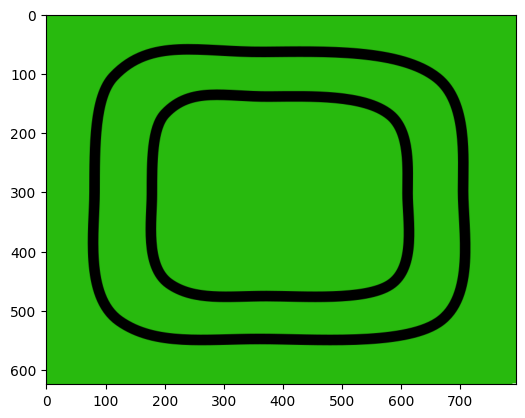

In [84]:
nom_imatge = "pista_6.png"

url = "https://lawer.github.io/mia/apunts/9.-Rob%C3%B3tica/" + nom_imatge

response = requests.get(url)

# Guardem la imatge

with open(nom_imatge, "wb") as f:
    f.write(response.content)

# Carreguem la imatge en una variable

img = cv2.imread(nom_imatge)

# Mostrem la imatge
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [85]:
world = bots.World(220, 180, boundary_wall_color="yellow", ground_image_filename=nom_imatge)

robot = bots.Scribbler(x=36, y=90, a=90)
robot.add_device(bots.GroundCamera(width=100, height=50))

world.add_robot(robot)

robot['ground-camera'].watch()
world.watch()

Random seed set to: 2878016


HTML(value='<style>img.pixelated {image-rendering: pixelated;}</style>')

HTML(value='<style>img.pixelated {image-rendering: pixelated;}</style>')

HTML(value='<style>img.pixelated {image-rendering: pixelated;}</style>')

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00d\x00\x00\x002\x08\x06\x00\x00\x00\xaa5~\xbe\x00\…

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x0…

In [86]:
world.reset()
world.seconds(30, [network_driver], real_time=True)

Using random seed: 2878016


  0%|          | 0/300 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step
Simulation stopped at: 00:00:30.00; speed 0.7 x real time


In [ ]:
# Guardem la xarxa
robot_net.save("robot")

INFO:tensorflow:Assets written to: robot/assets


INFO:tensorflow:Assets written to: robot/assets


## Preguntes a respondre

1. Cal algún tipus de memòria per aconseguir que el robot arribi a l'objectiu? Per què?
   
2. Quin percentatge de les dades d'entrenament fan que el robot es mogui cap endavant, cap a l'esquerra i cap a la dreta?

3. Quina mida de capa oculta us ha funcionat millor?

4. El funcionament del robot controlat per la xarxa neuronal és millor, pitjor o igual que el funcionament del robot controlat pel vostre algorisme? Podríeu explicar per què?

5. Com podriem fer per no necessitar fer el processament amb OpenCV?

## Conclusions

En aquesta pràctica hem après a controlar un robot utilitzant una xarxa neuronal. Hem vist com entrenar la xarxa neuronal amb dades de sensors i comandes i com utilitzar la xarxa per controlar el robot. Hem vist que la xarxa neuronal pot ser una eina potent per controlar robots, però que pot ser necessari un temps d'entrenament més llarg que amb altres mètodes. També hem vist que és important balancejar les dades d'entrenament perquè la xarxa neuronal aprengui bé.

A vegades pot no ser fàcil aconseguir les dades d'entrenament necessàries per aconseguir que la xarxa neuronal funcioni bé. En aquest cas, hem utilitzat dades simulades, però en un entorn real, podria ser més complicat.

En la pròxima pràctica, veurem com entrenar una xarxa neuronal per controlar un robot sense necessitat de dades d'entrenament.